# Mall Customers Segmentation 

In [1]:
# Packages
#-----------Generic-------------#
import pandas as pd
import numpy as np 
import seaborn as snb
import matplotlib.pyplot as plt
import warnings
%matplotlib inline
#---------Algorithms-------------------#
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import accuracy_score , silhouette_score
from sklearn.cluster import KMeans
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import ConfusionMatrixDisplay, classification_report, confusion_matrix
#----------Clustering-----------#
from pyclustering.cluster.kmeans import kmeans
from pyclustering.utils.metric import type_metric, distance_metric
from pyclustering.utils.metric import distance_metric
from pyclustering.cluster.center_initializer import random_center_initializer
from pyclustering.cluster.encoder import cluster_encoder

In [2]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.filterwarnings(action='ignore' ,category=UserWarning)

In [3]:
# %pip install pyclustering

In [4]:
df = pd.read_csv('Mall_Customers.csv')
print ("data has been read")

data has been read


In [5]:
df.head(10)

,CustomerID,Genre,Age,Annual_Income_(k$),Spending_Score
0,1,Male,19,15,39
1,2,Male,21,15,81
2,3,Female,20,16,6
3,4,Female,23,16,77
4,5,Female,31,17,40
5,6,Female,22,17,76
6,7,Female,35,18,6
7,8,Female,23,18,94
8,9,Male,64,19,3
9,10,Female,30,19,72


In [6]:
df.describe()

,CustomerID,Age,Annual_Income_(k$),Spending_Score
count,200.000000,200.000000,200.000000,200.000000
mean,100.500000,38.850000,60.560000,50.200000
std,57.879185,13.969007,26.264721,25.823522
min,1.000000,18.000000,15.000000,1.000000
25%,50.750000,28.750000,41.500000,34.750000
50%,100.500000,36.000000,61.500000,50.000000
75%,150.250000,49.000000,78.000000,73.000000
max,200.000000,70.000000,137.000000,99.000000


In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200 entries, 0 to 199
Data columns (total 5 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   CustomerID          200 non-null    int64 
 1   Genre               200 non-null    object
 2   Age                 200 non-null    int64 
 3   Annual_Income_(k$)  200 non-null    int64 
 4   Spending_Score      200 non-null    int64 
dtypes: int64(4), object(1)
memory usage: 7.9+ KB


In [8]:
df.isnull().sum()

CustomerID            0
Genre                 0
Age                   0
Annual_Income_(k$)    0
Spending_Score        0
dtype: int64

In [9]:
df.rename(index=str, columns={'Annual_Income_(k$)': 'Income',
                              'Spending_Score': 'Score'}, inplace=True)
df.head()

,CustomerID,Genre,Age,Income,Score
0,1,Male,19,15,39
1,2,Male,21,15,81
2,3,Female,20,16,6
3,4,Female,23,16,77
4,5,Female,31,17,40


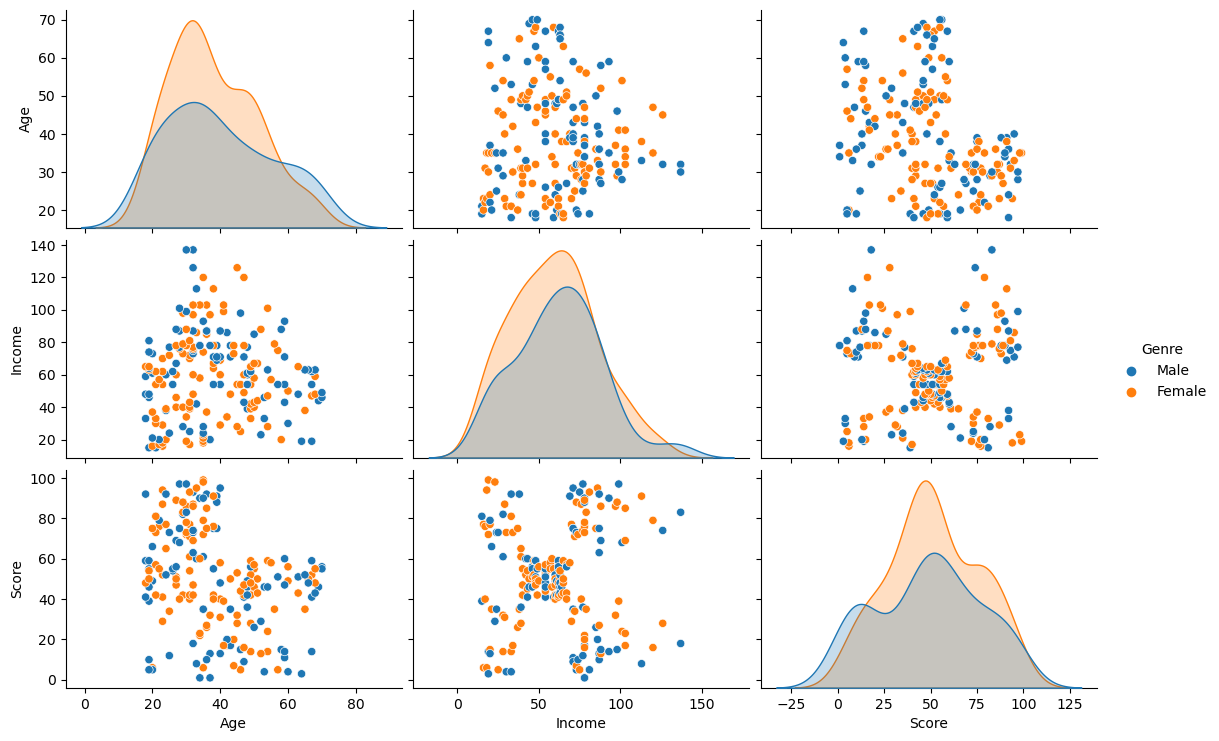

In [10]:
df_drop = df.drop(['CustomerID', 'Genre'], axis=1)
snb.pairplot(df.drop('CustomerID', axis=1), hue='Genre', aspect=1.5)
plt.show()

### it observed that 'customerID' and 'Gender' has no direct relation to segmenting customers so will be dropping those features and will be using 'df_drop' moving forward

In [11]:
df_drop.head()

,Age,Income,Score
0,19,15,39
1,21,15,81
2,20,16,6
3,23,16,77
4,31,17,40


In [12]:
scaler_MinMax = MinMaxScaler().fit_transform(df_drop)
scaler_MinMax[:5]

scaled_df = pd.DataFrame(scaler_MinMax, columns=df_drop.columns)

## k-means clustering using Manhattan distance as the distance-measure

In [13]:
# Convert the scaled data back to a DataFrame with the same columns
scaled_df = pd.DataFrame(scaler_MinMax, columns=df_drop.columns)

data = scaled_df.values

# Set the number of clusters
k = 3

# Initialize random cluster centers with the same dimension as the data
initial_centers = random_center_initializer(data, k, random_state=5).initialize()

# Distance metric 2 for Manhattan
kmeans_manhattan = kmeans(data, initial_centers=initial_centers, metric=distance_metric(type_metric.MANHATTAN))
kmeans_manhattan.process()
py_clusters = kmeans_manhattan.get_clusters()
py_centers = kmeans_manhattan.get_centers()
py_encoding = kmeans_manhattan.get_cluster_encoding()
py_encoder = cluster_encoder(py_encoding, py_clusters, data)
py_labels = py_encoder.set_encoding(0).get_clusters()
scaled_df['Labels'] = py_labels

print('Running k-means clustering with Manhattan distance...')
print('Applying the labels based on k-means...')
print('Data after labeling...')
scaled_df['Labels'] = scaled_df['Labels'].astype(str)
scaled_df.head(12)

Running k-means clustering with Manhattan distance...
Applying the labels based on k-means...
Data after labeling...


,Age,Income,Score,Labels
0,0.019231,0.000000,0.387755,2
1,0.057692,0.000000,0.816327,2
2,0.038462,0.008197,0.051020,0
3,0.096154,0.008197,0.775510,2
4,0.250000,0.016393,0.397959,1
5,0.076923,0.016393,0.765306,2
6,0.326923,0.024590,0.051020,0
7,0.096154,0.024590,0.948980,2
8,0.884615,0.032787,0.020408,1
9,0.230769,0.032787,0.724490,2


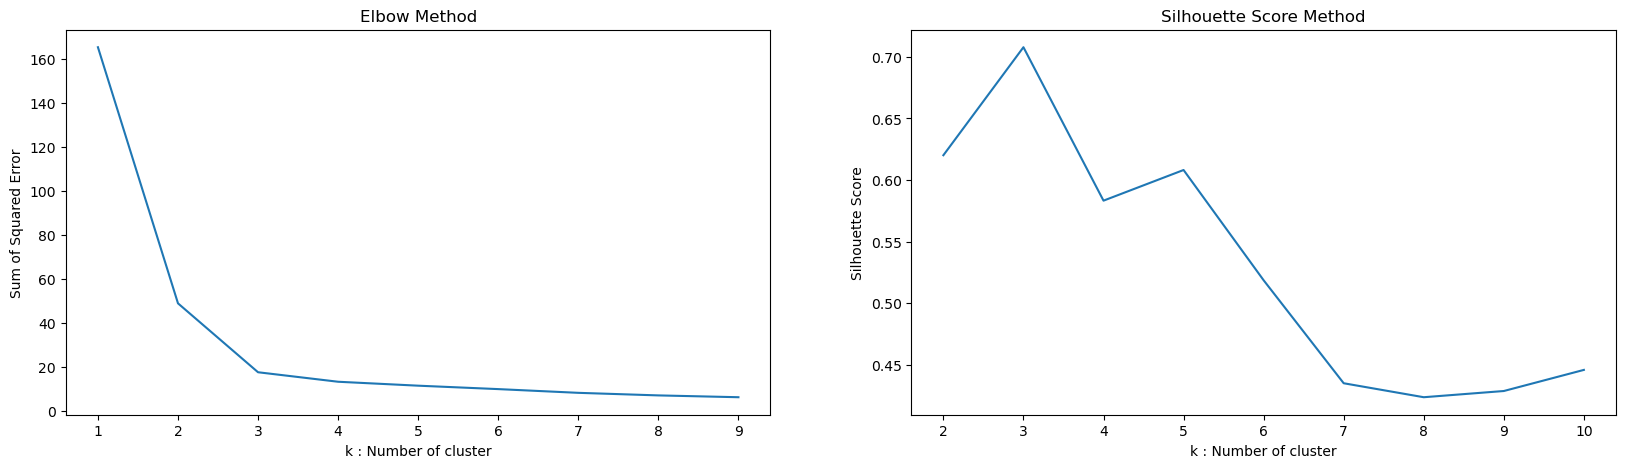

In [14]:
sse = {};sil = [];kmax = 10
fig = plt.subplots(nrows = 1, ncols = 2, figsize = (20,5))

# Elbow Method :
plt.subplot(1,2,1)
for k in range(1, 10):
    kmeans = KMeans(n_clusters=k, max_iter=1000).fit(scaled_df)
    sse[k] = kmeans.inertia_ # Inertia: Sum of distances of samples to their closest cluster center
snb.lineplot(x = list(sse.keys()), y = list(sse.values()));
plt.title('Elbow Method')
plt.xlabel("k : Number of cluster")
plt.ylabel("Sum of Squared Error")

# Silhouette Score Method
plt.subplot(1,2,2)
for k in range(2, kmax + 1):
    kmeans = KMeans(n_clusters = k).fit(scaled_df)
    labels = kmeans.labels_
    sil.append(silhouette_score(scaled_df, labels, metric = 'manhattan'))
snb.lineplot(x = range(2,kmax + 1), y = sil);
plt.title('Silhouette Score Method')
plt.xlabel("k : Number of cluster")
plt.ylabel("Silhouette Score")
plt.show()

## Train Test Split the data for Standard Classification

In [15]:
# Split the dataset into training and testing sets
from sklearn.model_selection import train_test_split

X = scaled_df[['Age', 'Income', 'Score']]
y = scaled_df[['Labels']]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Print the shapes of the resulting sets
print("Training set:", X_train.shape, y_train.shape)
print("Testing set:", X_test.shape, y_test.shape)

Training set: (140, 3) (140, 1)
Testing set: (60, 3) (60, 1)


### Logistic regression Classification

Logistic Regression Accuracy: 0.9333333333333333
Logistic Regression Classification Report:
               precision    recall  f1-score   support

           0       1.00      0.76      0.87        17
           1       0.90      1.00      0.95        18
           2       0.93      1.00      0.96        25

    accuracy                           0.93        60
   macro avg       0.94      0.92      0.93        60
weighted avg       0.94      0.93      0.93        60

confusion matrix for Logistic Regression



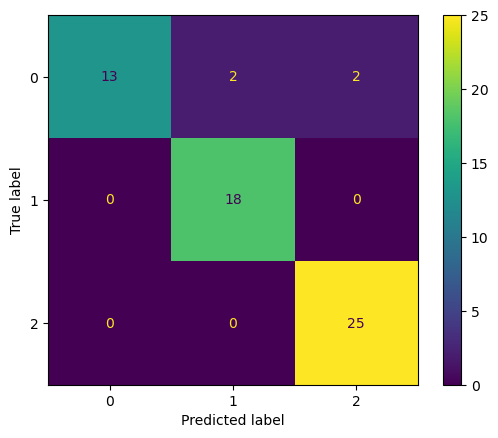

In [16]:
# Create and train the logistic regression model
logistic_reg_model = LogisticRegression()
logistic_reg_model.fit(X_train, y_train)

# Make predictions on the test set
logistic_reg_predictions = logistic_reg_model.predict(X_test)

# Evaluate the model
print("Logistic Regression Accuracy:", accuracy_score(y_test, logistic_reg_predictions))
print("Logistic Regression Classification Report:\n", classification_report(y_test, logistic_reg_predictions))
print('confusion matrix for Logistic Regression\n')
cm = confusion_matrix(y_test.values.ravel(), logistic_reg_predictions, labels=logistic_reg_model.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=logistic_reg_model.classes_)
disp.plot()
plt.show()

### Decision Tree Classification

Decision Tree Accuracy: 0.95
Decision Tree Classification Report:
               precision    recall  f1-score   support

           0       1.00      0.94      0.97        17
           1       0.94      0.94      0.94        18
           2       0.92      0.96      0.94        25

    accuracy                           0.95        60
   macro avg       0.96      0.95      0.95        60
weighted avg       0.95      0.95      0.95        60



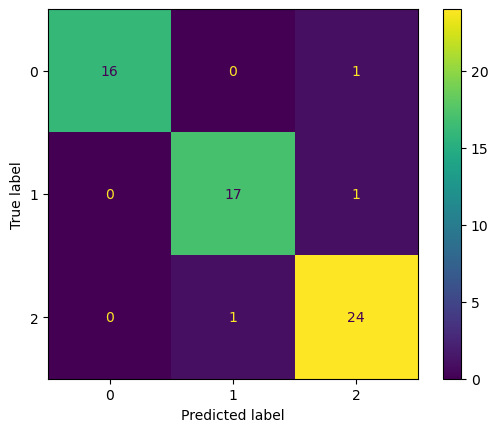

In [17]:
# Create and train the decision tree model
decision_tree_model = DecisionTreeClassifier()
decision_tree_model.fit(X_train, y_train)

# Make predictions on the test set
decision_tree_predictions = decision_tree_model.predict(X_test)

# Evaluate the model
print("Decision Tree Accuracy:", accuracy_score(y_test, decision_tree_predictions))
print("Decision Tree Classification Report:\n", classification_report(y_test, decision_tree_predictions))
cm = confusion_matrix(y_test.values.ravel(), decision_tree_predictions, labels=decision_tree_model.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=decision_tree_model.classes_)
disp.plot()
plt.show()


### Random Forest Classification

Random Forest Accuracy: 1.0
Random Forest Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00        17
           1       1.00      1.00      1.00        18
           2       1.00      1.00      1.00        25

    accuracy                           1.00        60
   macro avg       1.00      1.00      1.00        60
weighted avg       1.00      1.00      1.00        60



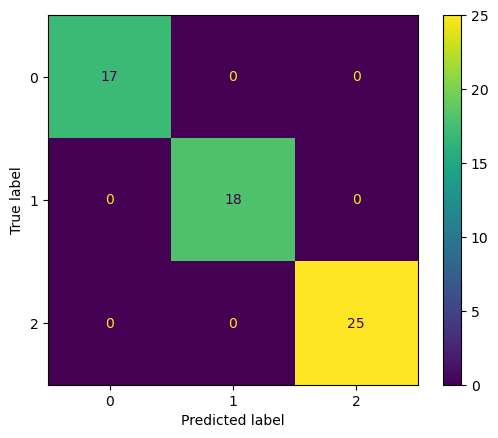

In [18]:
# Create and train the random forest model
random_forest_model = RandomForestClassifier()
random_forest_model.fit(X_train, y_train)

# Make predictions on the test set
random_forest_predictions = random_forest_model.predict(X_test)

# Evaluate the model
print("Random Forest Accuracy:", accuracy_score(y_test, random_forest_predictions))
print("Random Forest Classification Report:\n", classification_report(y_test, random_forest_predictions))
cm = confusion_matrix(y_test.values.ravel(), random_forest_predictions, labels=random_forest_model.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=random_forest_model.classes_)
disp.plot()
plt.show()

### Gusssian Naive Bayes Classifiction

Naive Bayes Accuracy: 0.9333333333333333
Naive Bayes Classification Report:
               precision    recall  f1-score   support

           0       0.93      0.82      0.87        17
           1       0.89      0.94      0.92        18
           2       0.96      1.00      0.98        25

    accuracy                           0.93        60
   macro avg       0.93      0.92      0.92        60
weighted avg       0.93      0.93      0.93        60



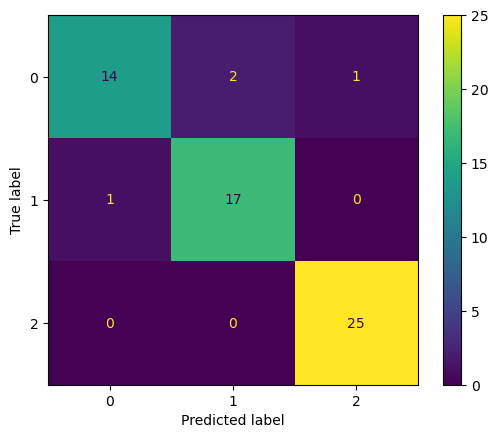

In [19]:
# Create and train the Naive Bayes model 
naive_bayes_model = GaussianNB()
naive_bayes_model.fit(X_train, y_train)

# Make predictions on the test set
naive_bayes_predictions = naive_bayes_model.predict(X_test)

# Evaluate the model
print("Naive Bayes Accuracy:", accuracy_score(y_test, naive_bayes_predictions))
print("Naive Bayes Classification Report:\n", classification_report(y_test, naive_bayes_predictions))
cm = confusion_matrix(y_test.values.ravel(), naive_bayes_predictions, labels=naive_bayes_model.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=naive_bayes_model.classes_)
disp.plot()
plt.show()

## Comments on Homogeneity of Clusters

#### Both models Decision Tree and Random Forest are showing good homogeneity in clusters as evidenced by high accuracy and balanced precision and recall for most classes.
#### The Random Forest model stands out with the highest accuracy and well-balanced performance across all classes.
#### The Decision Tree model also performs well, but it slightly lags behind the Random Forest in accuracy.

##### Overall, the clusters seem to make sense, and the models are doing a good job of distinguishing between the classes. The high accuracy scores and balanced precision and recall metrics across most classes indicate that these models are effective in classifying the data and thus indicating that homogenity is actually perserved in the clustering of the data by k-means cluster.

# Breast Cancer Dataset

In [20]:
from sklearn.datasets import load_breast_cancer
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
%matplotlib inline
# sns.set_style('whitegrid')

from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.metrics import confusion_matrix

In [21]:
# Load the breast cancer dataset
cancer = load_breast_cancer()
# Convert the data to a pandas DataFrame
col_names = list(cancer.feature_names)
col_names.append('target')
breast_cancer_df = pd.DataFrame(np.c_[cancer.data, cancer.target], columns=col_names)

In [22]:
breast_cancer_df.head(12)

,mean radius,mean texture,mean perimeter,mean area,mean smoothness,mean compactness,mean concavity,mean concave points,mean symmetry,mean fractal dimension,...,worst texture,worst perimeter,worst area,worst smoothness,worst compactness,worst concavity,worst concave points,worst symmetry,worst fractal dimension,target
0,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.30010,0.14710,0.2419,0.07871,...,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.26540,0.4601,0.11890,0.0
1,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.08690,0.07017,0.1812,0.05667,...,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.18600,0.2750,0.08902,0.0
2,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.19740,0.12790,0.2069,0.05999,...,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.24300,0.3613,0.08758,0.0
3,11.42,20.38,77.58,386.1,0.14250,0.28390,0.24140,0.10520,0.2597,0.09744,...,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.25750,0.6638,0.17300,0.0
4,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.19800,0.10430,0.1809,0.05883,...,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.16250,0.2364,0.07678,0.0
5,12.45,15.70,82.57,477.1,0.12780,0.17000,0.15780,0.08089,0.2087,0.07613,...,23.75,103.40,741.6,0.1791,0.5249,0.5355,0.17410,0.3985,0.12440,0.0
6,18.25,19.98,119.60,1040.0,0.09463,0.10900,0.11270,0.07400,0.1794,0.05742,...,27.66,153.20,1606.0,0.1442,0.2576,0.3784,0.19320,0.3063,0.08368,0.0
7,13.71,20.83,90.20,577.9,0.11890,0.16450,0.09366,0.05985,0.2196,0.07451,...,28.14,110.60,897.0,0.1654,0.3682,0.2678,0.15560,0.3196,0.11510,0.0
8,13.00,21.82,87.50,519.8,0.12730,0.19320,0.18590,0.09353,0.2350,0.07389,...,30.73,106.20,739.3,0.1703,0.5401,0.5390,0.20600,0.4378,0.10720,0.0
9,12.46,24.04,83.97,475.9,0.11860,0.23960,0.22730,0.08543,0.2030,0.08243,...,40.68,97.65,711.4,0.1853,1.0580,1.1050,0.22100,0.4366,0.20750,0.0


In [23]:
breast_cancer_df.columns

Index(['mean radius', 'mean texture', 'mean perimeter', 'mean area',
       'mean smoothness', 'mean compactness', 'mean concavity',
       'mean concave points', 'mean symmetry', 'mean fractal dimension',
       'radius error', 'texture error', 'perimeter error', 'area error',
       'smoothness error', 'compactness error', 'concavity error',
       'concave points error', 'symmetry error', 'fractal dimension error',
       'worst radius', 'worst texture', 'worst perimeter', 'worst area',
       'worst smoothness', 'worst compactness', 'worst concavity',
       'worst concave points', 'worst symmetry', 'worst fractal dimension',
       'target'],
      dtype='object')

In [24]:
features_mean= list(breast_cancer_df.columns[1:11])
features_se= list(breast_cancer_df.columns[11:20])
features_worst=list(breast_cancer_df.columns[21:31])
print(features_mean)
print("-----------------------------------")
print(features_se)
print("------------------------------------")
print(features_worst)

['mean texture', 'mean perimeter', 'mean area', 'mean smoothness', 'mean compactness', 'mean concavity', 'mean concave points', 'mean symmetry', 'mean fractal dimension', 'radius error']
-----------------------------------
['texture error', 'perimeter error', 'area error', 'smoothness error', 'compactness error', 'concavity error', 'concave points error', 'symmetry error', 'fractal dimension error']
------------------------------------
['worst texture', 'worst perimeter', 'worst area', 'worst smoothness', 'worst compactness', 'worst concavity', 'worst concave points', 'worst symmetry', 'worst fractal dimension', 'target']


In [25]:
breast_cancer_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 569 entries, 0 to 568
Data columns (total 31 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   mean radius              569 non-null    float64
 1   mean texture             569 non-null    float64
 2   mean perimeter           569 non-null    float64
 3   mean area                569 non-null    float64
 4   mean smoothness          569 non-null    float64
 5   mean compactness         569 non-null    float64
 6   mean concavity           569 non-null    float64
 7   mean concave points      569 non-null    float64
 8   mean symmetry            569 non-null    float64
 9   mean fractal dimension   569 non-null    float64
 10  radius error             569 non-null    float64
 11  texture error            569 non-null    float64
 12  perimeter error          569 non-null    float64
 13  area error               569 non-null    float64
 14  smoothness error         5

In [26]:
# breast_cancer_df.target_names

unique_targets = breast_cancer_df['target'].unique()
print(unique_targets)


[0. 1.]


In [27]:
breast_cancer_df.describe()

,mean radius,mean texture,mean perimeter,mean area,mean smoothness,mean compactness,mean concavity,mean concave points,mean symmetry,mean fractal dimension,...,worst texture,worst perimeter,worst area,worst smoothness,worst compactness,worst concavity,worst concave points,worst symmetry,worst fractal dimension,target
count,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,...,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000
mean,14.127292,19.289649,91.969033,654.889104,0.096360,0.104341,0.088799,0.048919,0.181162,0.062798,...,25.677223,107.261213,880.583128,0.132369,0.254265,0.272188,0.114606,0.290076,0.083946,0.627417
std,3.524049,4.301036,24.298981,351.914129,0.014064,0.052813,0.079720,0.038803,0.027414,0.007060,...,6.146258,33.602542,569.356993,0.022832,0.157336,0.208624,0.065732,0.061867,0.018061,0.483918
min,6.981000,9.710000,43.790000,143.500000,0.052630,0.019380,0.000000,0.000000,0.106000,0.049960,...,12.020000,50.410000,185.200000,0.071170,0.027290,0.000000,0.000000,0.156500,0.055040,0.000000
25%,11.700000,16.170000,75.170000,420.300000,0.086370,0.064920,0.029560,0.020310,0.161900,0.057700,...,21.080000,84.110000,515.300000,0.116600,0.147200,0.114500,0.064930,0.250400,0.071460,0.000000
50%,13.370000,18.840000,86.240000,551.100000,0.095870,0.092630,0.061540,0.033500,0.179200,0.061540,...,25.410000,97.660000,686.500000,0.131300,0.211900,0.226700,0.099930,0.282200,0.080040,1.000000
75%,15.780000,21.800000,104.100000,782.700000,0.105300,0.130400,0.130700,0.074000,0.195700,0.066120,...,29.720000,125.400000,1084.000000,0.146000,0.339100,0.382900,0.161400,0.317900,0.092080,1.000000
max,28.110000,39.280000,188.500000,2501.000000,0.163400,0.345400,0.426800,0.201200,0.304000,0.097440,...,49.540000,251.200000,4254.000000,0.222600,1.058000,1.252000,0.291000,0.663800,0.207500,1.000000


In [28]:
# Define features (X) and target (y)
X = breast_cancer_df.drop(columns=['target'])
y = breast_cancer_df['target']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Print the shapes of the resulting sets
print("Training set:", X_train.shape, y_train.shape)
print("Testing set:", X_test.shape, y_test.shape)

print("X:", X.shape)
print("y", y.shape)


Training set: (398, 30) (398,)
Testing set: (171, 30) (171,)
X: (569, 30)
y (569,)


In [29]:
pca = PCA(n_components=2)
scaler = StandardScaler()

X_train = pca.fit_transform(X_train)
X_test = pca.transform(X_test)

X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

Text(0, 0.5, 'Second Principal Component')

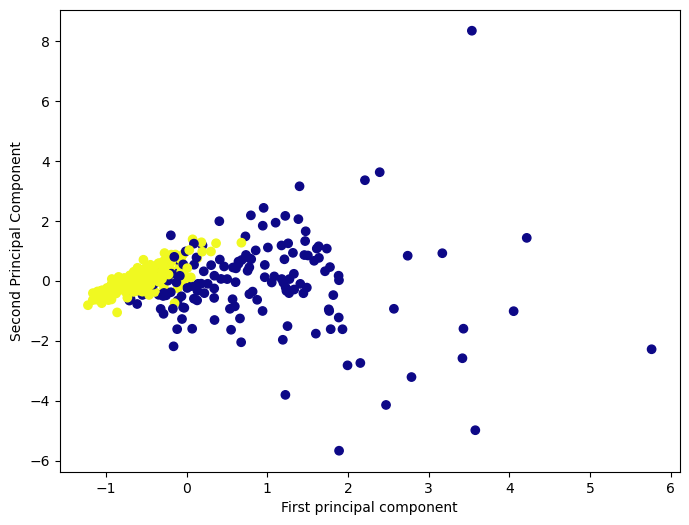

In [30]:
plt.figure(figsize=(8,6))
plt.scatter(X_train[:,0],X_train[:,1],c=y_train,cmap='plasma')
plt.xlabel('First principal component')
plt.ylabel('Second Principal Component')

In [31]:
# Standardize the data
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Apply Linear Discriminant Analysis (LDA)
lda = LDA(n_components=1)
X_train_lda = lda.fit_transform(X_train_scaled, y_train)
X_test_lda = lda.transform(X_test_scaled)

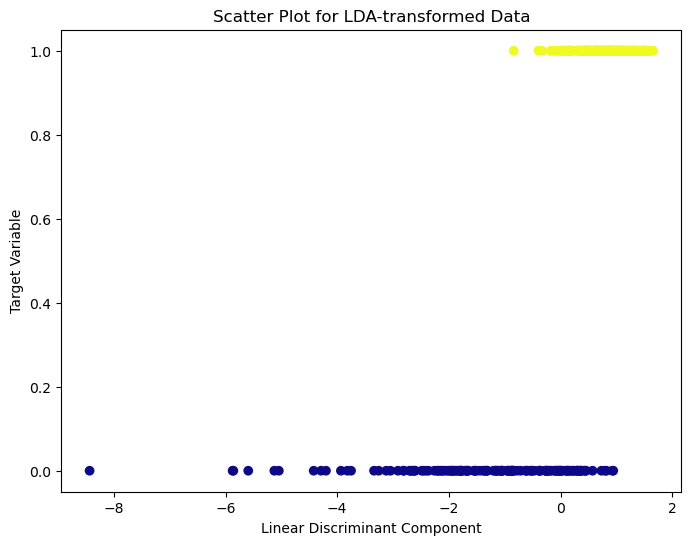

In [32]:
# Create a scatter plot for LDA
plt.figure(figsize=(8, 6))
plt.scatter(X_train_lda, y_train, c=y_train, cmap='plasma')
plt.xlabel('Linear Discriminant Component')
plt.ylabel('Target Variable')
plt.title('Scatter Plot for LDA-transformed Data')
plt.show()


In [33]:
# Maximum variance explained by PCA components
max_variance_pca = pca.explained_variance_ratio_.sum()
print(f"Maximum variance explained by PCA components: {max_variance_pca:.4f}")

# Maximum variance explained by LDA components
max_variance_lda = lda.explained_variance_ratio_.sum()
print(f"Maximum variance explained by LDA components: {max_variance_lda:.4f}")

Maximum variance explained by PCA components: 0.9979
Maximum variance explained by LDA components: 1.0000


## Conclusion 

#### The high variance explained by LDA indicates that it is effective in summarizing the breast_cancer dataset. Also the perfect separation achieved by LDA suggests that it is highly effective for class discrimination in this specific dataset.

#### For the breast cancer dataset, where the goal is often classification between malignant and benign tumors, the excellent performance of LDA suggests that it may be a preferred choice.